In [23]:
from neuralnet import *

# Just for loading indicator, just remove it from 'for-loops' if don't have this lib
from tqdm import tqdm_notebook as tqdm

## a) Load data

In [24]:
train_data_fname = 'data/MNIST_train.pkl'
valid_data_fname = 'data/MNIST_valid.pkl'
test_data_fname = 'data/MNIST_test.pkl'

### Train the network ###
model = Neuralnetwork(config)
X_train, y_train = load_data(train_data_fname)
X_valid, y_valid = load_data(valid_data_fname)
X_test, y_test = load_data(test_data_fname)

## b) Check with gradient approximation

Below we have a function to test numerical approximation for all possible units in the network, then return ratio of those that are within O(epsilon^2) bounds.

### All Bias Checks

In [25]:
def test_approximation_bias(model, layer_ind, unit_ind, epsilon=1e-2, report_mode=False):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[0,:].reshape((1,-1))
  y_sample = y_test[0,:].reshape((1,-1))

  original_w = model.layers[layer_ind].b[0,unit_ind]
  
  # Approximation
  model.layers[layer_ind].b[0,unit_ind] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].b[0,unit_ind] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].b[0,unit_ind] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_b[unit_ind]/len(X_sample)
  
  if report_mode:
    print("Estimated:", estimated_dE_dw, "Actual BPP:", bpp_dE_dw, "Abs Diff", abs(estimated_dE_dw - bpp_dE_dw))
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
print("Check all possible biases...")
# BIAS CHECK
EPSILON = 1e-4
checks = []
model = Neuralnetwork(config)
for layer_i in tqdm([0, 2]):
  for unit_i in range(model.layers[layer_i].b.shape[1]):
    raw_diff, is_close_enough = test_approximation_bias(model, layer_i, unit_i, EPSILON)
    checks.append(is_close_enough)
    
print("Percent of weight approximation within bounds:", sum(checks)/len(checks))

Check all possible biases...



Percent of weight approximation within bounds: 1.0


### Individual checks for report

In [26]:
model = Neuralnetwork(config)
for ep in [1e-1, 1e-2, 1e-3, 1e-4]:
  print("Epsilon:", ep)
  test_approximation_bias(model, 0, 5, epsilon=ep, report_mode=True)
  print("---------")

Epsilon: 0.1
Estimated: 9.129941247465467e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 6.049721824057006e-12
---------
Epsilon: 0.01
Estimated: 9.070078021977679e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 6.339927527816159e-14
---------
Epsilon: 0.001
Estimated: 9.07718344933528e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 7.739420110382618e-13
---------
Epsilon: 0.0001
Estimated: 9.059419880941277e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 1.0024148283619887e-12
---------


### All Weights Checks

In [27]:
def test_approximation_weight(model, layer_ind, unit_in, unit_out, epsilon=1e-2, report_mode=False):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[sample_test,:].reshape((1,-1))
  y_sample = y_test[sample_test,:].reshape((1,-1))

  original_w = model.layers[layer_ind].w[unit_in, unit_out]
  
  # Approximation
  model.layers[layer_ind].w[unit_in, unit_out] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].w[unit_in, unit_out] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].w[unit_in, unit_out] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_w[unit_in, unit_out]/len(X_sample)
  
  if report_mode:
    print("Estimated:", estimated_dE_dw, "Actual BPP:", bpp_dE_dw, "Abs Diff", abs(estimated_dE_dw - bpp_dE_dw))
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# MASS BIAS CHECK
print("Check multiple weights, maximum of 100...")
checks = []
model = Neuralnetwork(config)
for layer_i in tqdm([0, 2]):
  for unit_in in tqdm(range(min(model.layers[layer_i].w.shape[0], 100))):
    for unit_out in range(min(model.layers[layer_i].w.shape[1], 100)):
      raw_diff, is_close_enough = test_approximation_weight(model, layer_i, unit_in, unit_out, EPSILON)
      checks.append(is_close_enough)
    
print("Percent of bias approximation within bounds:", sum(checks)/len(checks))

Check multiple weights, maximum of 100...



Percent of bias approximation within bounds: 1.0


### Individual weight check for report

In [28]:
model = Neuralnetwork(config)
for ep in [1e-1, 1e-2, 1e-3, 1e-4]:
  print("Epsilon:", ep)
  test_approximation_weight(model, 0, 290, 22, epsilon=ep, report_mode=True)
  print("---------")

Epsilon: 0.1
Estimated: -3.1443283532439636e-08 Actual BPP: -3.123464274458815e-08 Abs Diff 2.0864078785148627e-10
---------
Epsilon: 0.01
Estimated: 0.0010964286848214044 Actual BPP: 0.0010963570128047493 Abs Diff 7.167201665513913e-08
---------
Epsilon: 0.001
Estimated: -0.39929861386056587 Actual BPP: -0.3992984508089363 Abs Diff 1.630516295869633e-07
---------
Epsilon: 0.0001
Estimated: 0.0 Actual BPP: -7.332949006261695e-16 Abs Diff 7.332949006261695e-16
---------


## c) Loss/Accuracy vs epoch

In [33]:
import matplotlib.pyplot as plt

def evaluate_model(config):
  """
    Train model with given config.
    Return train_report that has train/valid losses and accuracies
  """
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  train_report = trainer(model, X_train, y_train, X_valid, y_valid, config, verbose=False)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)
  return {
    'config': config,
    'model': model,
    'train_report': train_report,
    'test_acc': test_acc
  }

def plot_from_train_report(train_report):
  """
    Plot two graphs from train_report: 1.train/valid losses vs epoch and 2. train/valid accuracies vs epoch
  """
  
  train_losses = train_report['train_losses']
  valid_losses = train_report['valid_losses']
  x = range(len(train_losses))
  
  plt.plot(x, train_losses, label='Train losses')
  plt.plot(x, valid_losses, label='Validation losses')
  plt.ylabel('Cross-Entropy Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation loss vs. Epoch')
  plt.show()
  
  
  train_accs = train_report['train_accuracies']
  valid_accs = train_report['valid_accuracies']
  x = range(len(train_accs))
  
  plt.plot(x, train_accs, label='Train accuracies')
  plt.plot(x, valid_accs, label='Validation accuracies')
  plt.ylabel('Accuracies')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation accuracy vs. Epoch')
  plt.show()

## Config for part c)

In [34]:
def default_config_part_c():
  """Return the default config used in part c)"""
  
  config = {}
  config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
  config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
  config['batch_size'] = 256  # Number of training samples per batch to be passed to network
  config['epochs'] = 100  # Number of epochs to train the model
  config['early_stop'] = True  # Implement early stopping or not
  config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
  config['L2_penalty'] = 0  # Regularization constant
  config['momentum'] = True  # Denotes if momentum is to be applied or not
  config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
  config['learning_rate'] = 0.05 # Learning rate of gradient descent algorithm
  return config

def custom_config_from_part_c(diff_config):
  """Return config modified from part c) with the provided dict"""
  
  config = default_config_part_c()
  for k,v in diff_config.items():
    config[k] = v
  return config
  

## Part c) Training

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Test Accuracy: 0.9149


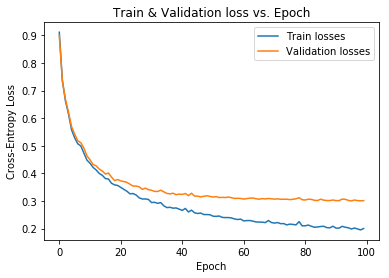

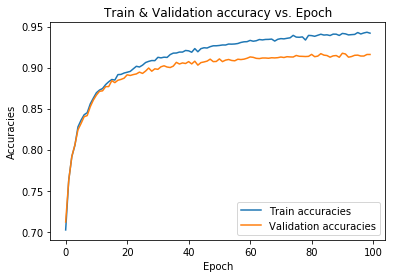

In [35]:
def partc():
  config = default_config_part_c()
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
partc()

## d) L2-Regularization Experiments

In [37]:
def partreg(l2lam=0.1):
  config = custom_config_from_part_c({
    'L2_penalty': l2lam,
    'epochs': 200,
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)

In [ ]:
partreg(1)

In [ ]:
partreg(0.1)

In [ ]:
partreg(0.001)

In [ ]:
partreg(0.0001)